In [25]:
import yfinance as yf
import datetime as dt
import streamlit as st 
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# ARIMA Forecast

In [26]:
# Function to check stationarity
def adf_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [27]:
df = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)
df_real=pd.read_csv('stock_data_real.csv', index_col='Date', parse_dates=True)

<AxesSubplot:title={'center':'Stock Closing Prices'}, xlabel='Date'>

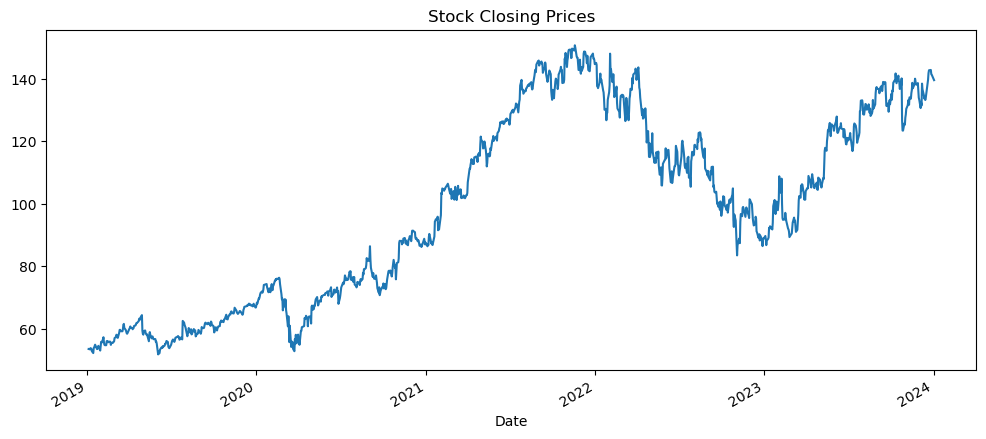

In [28]:
df['Close'].plot(figsize=(12, 5), title='Stock Closing Prices')

In [29]:
# Check for Stationarity
adf_test(df['Close'])

1. ADF :  -1.2152527678838654
2. P-Value :  0.667000181911724
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1255
5. Critical Values :
	 1% :  -3.435571295403709
	 5% :  -2.863845736356174
	 10% :  -2.567997600196822


In [30]:
# Figure Out Order for ARIMA Model
stepwise_fit = auto_arima(df['Close'], suppress_warnings=True)
best_order = stepwise_fit.order
print('Best ARIMA Order:', best_order)

Best ARIMA Order: (1, 1, 1)


In [31]:
train = df
test = df_real

In [32]:
model = ARIMA(train['Close'], order=best_order)
model = model.fit()

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [33]:
# Make Predictions on Test Data
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [34]:
rmse = sqrt(mean_squared_error(pred, test['Close']))
print('Root Mean Squared Error (RMSE):', rmse)

Root Mean Squared Error (RMSE): 3.192338591317749


In [35]:
# Train the Model on Entire Dataset
final_model = ARIMA(df['Close'], order=best_order)
final_model = final_model.fit()

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [36]:
future_dates = pd.date_range(start=df.index[-1], periods=17, freq='B')[1:]
pred_future = final_model.predict(start=len(df), end=len(df) + 15, typ='levels').rename('ARIMA Predictions')
pred_future.index = future_dates
# Print and Plot Predictions for Future Dates
print(pred_future)

2024-01-03    139.553194
2024-01-04    139.547603
2024-01-05    139.543008
2024-01-08    139.539232
2024-01-09    139.536128
2024-01-10    139.533578
2024-01-11    139.531481
2024-01-12    139.529759
2024-01-15    139.528343
2024-01-16    139.527180
2024-01-17    139.526223
2024-01-18    139.525438
2024-01-19    139.524792
2024-01-22    139.524261
2024-01-23    139.523825
2024-01-24    139.523466
Freq: B, Name: ARIMA Predictions, dtype: float64


D:\Installed\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



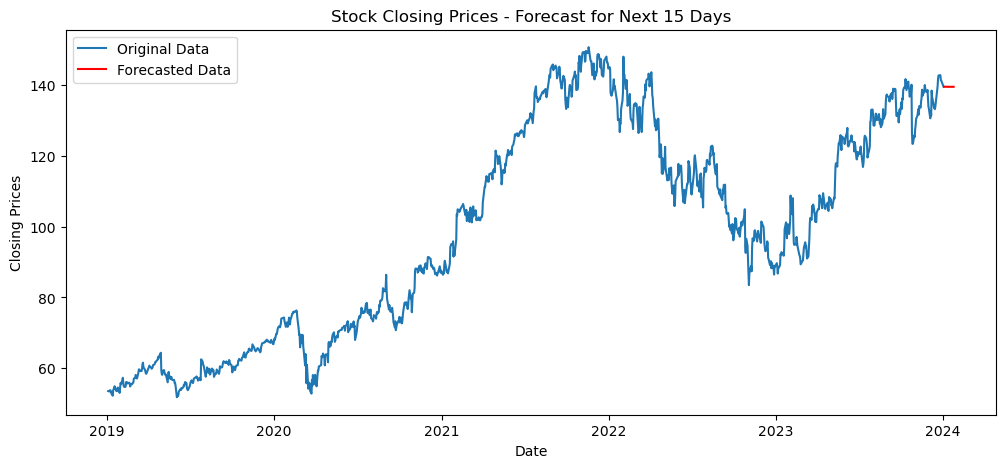

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Original Data')
plt.plot(pred_future, color='red', label='Forecasted Data')
plt.title('Stock Closing Prices - Forecast for Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

# LSTM Model


# Prophet Model Forecast  

In [2]:
import yfinance as yf
import datetime as dt
import streamlit as st 
import pandas as pd
import numpy as np
import yfinance as yf
# from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
# from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

symbol = 'TSLA'

# Calculate the start and end dates
end_date = dt.datetime.now() - dt.timedelta(days=15)
start_date = end_date - dt.timedelta(days=(3*365))

end_date_real = dt.datetime.now() 
start_date_real = end_date_real - dt.timedelta(days=15)


# Download the stock data
stock_data = yf.download(symbol, start=start_date, end=end_date_real, interval="1d").reset_index()

# Print the first few rows of the data
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2021-02-02  281.559998  293.500000  280.733337  290.929993  290.929993   
1 2021-02-03  292.339996  292.693329  284.353333  284.896667  284.896667   
2 2021-02-04  285.000000  285.500000  277.806671  283.329987  283.329987   
3 2021-02-05  281.666656  288.256653  279.656677  284.076660  284.076660   
4 2021-02-08  289.890015  292.589996  284.916656  287.806671  287.806671   

     Volume  
0  73038600  
1  55030500  
2  47438100  
3  55699800  
4  60485100  


In [3]:

stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
761,2024-02-12,192.110001,194.729996,187.279999,188.130005,188.130005,95498600
762,2024-02-13,183.990005,187.259995,182.110001,184.020004,184.020004,86759500
763,2024-02-14,185.300003,188.889999,183.350006,188.710007,188.710007,81203000
764,2024-02-15,189.160004,200.880005,188.860001,200.449997,200.449997,120831800
765,2024-02-16,202.059998,203.169998,197.399994,199.949997,199.949997,111173600


In [4]:
import pandas as pd 


In [20]:
df_real=stock_data[['Date','Close']]
df_real.rename(columns={'Date': 'ds', ' Close':'y'}, inplace=True)

C:\Users\Huzaifa Shah\AppData\Local\Temp\ipykernel_6820\3676520288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real.rename(columns={'Date': 'ds', ' Close':'y'}, inplace=True)


In [21]:
df=stock_data[['Date','Close']]


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    766 non-null    datetime64[ns]
 1   Close   766 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB


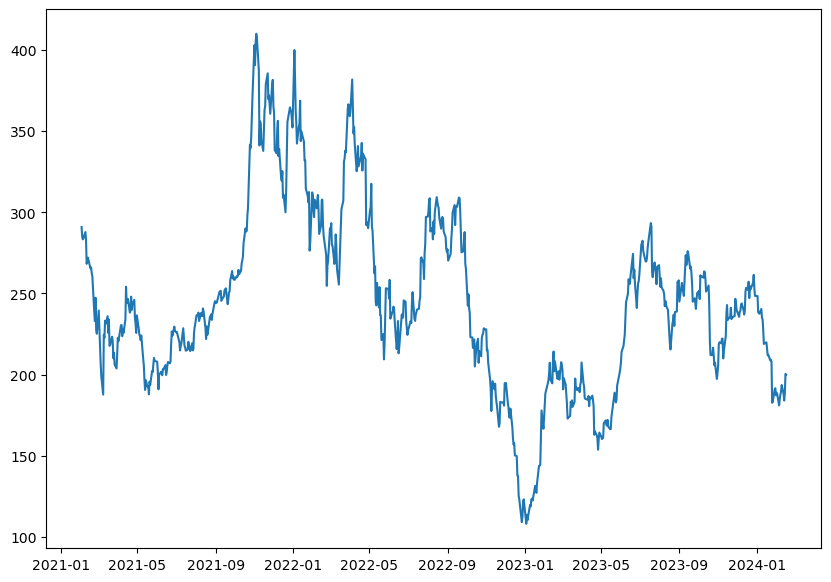

In [23]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,7))
plt.plot(df['Date'],df['Close'])

In [28]:
from prophet import Prophet 
# Assuming your original dataframe has columns 'Date' and 'Value'
# Rename them to 'ds' and 'y', respectively
df_real.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Convert the 'ds' column to datetime format (if not already done)
df_real['ds'] = pd.to_datetime(df_real['ds'])

# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df_real)



C:\Users\Huzaifa Shah\AppData\Local\Temp\ipykernel_6820\1052549385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
C:\Users\Huzaifa Shah\AppData\Local\Temp\ipykernel_6820\1052549385.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['ds'] = pd.to_datetime(df_real['ds'])
09:20:00 - cmdstanpy - INFO - Chain [1] start processing
09:20:01 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
future=model.make_future_dataframe(periods=freq='D')
future

TypeError: make_future_dataframe() missing 1 required positional argument: 'periods'

In [42]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming you have already set up your Prophet model and trained it on your data (df_real)
# Make sure your df_real dataframe has columns 'ds' and 'y'

# Define the start date (February 17, 2024)
start_date = datetime(2024, 2, 17)

# Create a date range for the next 7 days
date_range = [start_date + timedelta(days=i) for i in range(7)]

# Create a pandas DataFrame with the 'ds' column containing the dates
future_df = pd.DataFrame({'ds': date_range})

# Now you have a dataframe that includes the next 7 days
# You can use this for forecasting with your Prophet model


In [43]:
forecast=model.predict(future_df)

In [44]:
print(forecast.tail())

          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2 2024-02-19  223.728368  178.151060  244.365205   223.728368   223.728368   
3 2024-02-20  223.643090  175.071044  243.846444   223.643090   223.643090   
4 2024-02-21  223.557811  174.294121  244.663937   223.557811   223.557811   
5 2024-02-22  223.472533  172.579332  244.096552   223.472533   223.472533   
6 2024-02-23  223.387254  169.428137  238.530808   223.387254   223.387254   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
2      -10.625542            -10.625542            -10.625542 -5.119259   
3      -12.562251            -12.562251            -12.562251 -5.540995   
4      -14.017338            -14.017338            -14.017338 -5.271148   
5      -17.233517            -17.233517            -17.233517 -6.586824   
6      -19.561435            -19.561435            -19.561435 -6.877127   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
2     -5

In [32]:
print((forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','trend']]).head())

          ds        yhat  yhat_lower  yhat_upper       trend
0 2021-02-02  238.939139  205.363093  271.435824  259.924671
1 2021-02-03  240.719604  207.554835  274.330181  259.729350
2 2021-02-04  240.940546  207.203115  274.480600  259.534029
3 2021-02-05  242.169798  208.557927  277.443429  259.338709
4 2021-02-08  247.958080  214.971488  280.372580  258.752747


In [35]:
# from sklearn.metrics import mean_squared_error as mse 
# mse=mse(y_actual,forecast['trend'])
# mse

<Figure size 1500x700 with 0 Axes>

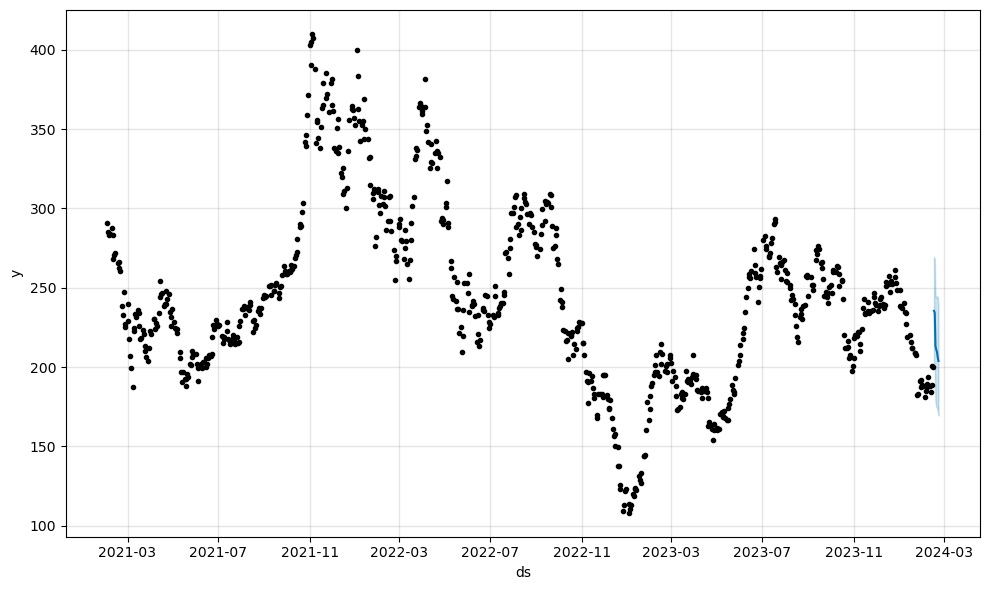

In [45]:
plt.figure(figsize=(15,7))
model.plot(forecast)
plt.show()

In [46]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)